## INSIGHTS ABOUT THE DATA PROVIDED
- The dataset contains 6 molecular descriptors and 1 target variable (LC50).
- The molecular descriptors are:
    - CIC0 (information indices)
    - SM1_Dz(Z) (2D matrix-based descriptors)
    - GATS1i (2D autocorrelations)
    - NdsCH (atom-type counts)
    - NdssC (atom-type counts)
    - MLOGP (molecular properties)
- The target variable, LC50, is the concentration that causes death in 50% of test fish over a test duration of 96 hours.
- The target variable is a quantitative experimental response.


## INFORMATION ABOUT LC50 (Lethal Concentration 50)
- LC50 is a measure of the toxicity of a substance.
- A lower LC50 value indicates higher toxicity.
- The unit of LC50 is [-LOG(mol/L)], which means the negative logarithm of the molar concentration.
- The effects of LC50 on test fish include:
    - Death (50% mortality rate)
    - Toxicity
    - Biochemical and physiological changes
    - Environmental impacts (if the substance is released into the environment)
- Predicting LC50 values is important in fields like:
    - Environmental science
    - Toxicology
    - Pharmacology
    - Chemical engineering


### STEP 01 : LOADING DATA AND DESCRIBING 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_csv("qsar_fish_toxicity.csv")

# Inspecting the structure of the dataset
display(data.info())
display(data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CIC0                906 non-null    float64
 1   SM1_Dz(Z)           906 non-null    float64
 2   GATS1i              906 non-null    float64
 3   NdsCH               907 non-null    float64
 4   NdssC               908 non-null    int64  
 5   MLOGP               905 non-null    float64
 6   LC50 [-LOG(mol/L)]  906 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 49.8 KB


None

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50 [-LOG(mol/L)]
count,906.000000,906.000000,906.000000,907.000000,908.000000,905.000000,906.000000
mean,2.898620,0.628595,1.297135,0.229327,0.504405,2.113989,4.063213
std,0.756221,0.428775,0.412765,0.605621,1.083596,1.480015,1.457018
min,0.667000,0.000000,0.396000,0.000000,-3.000000,-5.780000,0.053000
25%,2.348750,0.223000,0.950250,0.000000,0.000000,1.209000,3.151250
50%,2.934000,0.570000,1.240500,0.000000,0.000000,2.127000,3.984000
75%,3.407000,0.896250,1.562750,0.000000,1.000000,3.109000,4.910500
max,5.926000,2.171000,4.980000,4.000000,20.000000,10.000000,9.612000


### STEP 02 : Replacing the 0's in the column 'SM1_Dz(Z)' to NA to simplify the treament of missing values 

In [3]:
# Replacing the 0's in the column 'SM1_Dz(Z)' to NA to simplify the treament of missing values 
data['SM1_Dz(Z)'] = data['SM1_Dz(Z)'].replace(0, np.nan)


### STEP 03 : MISSING VALUE TREATMENT USING KNN IMPUTATION

##### KNN (K-Nearest Neighbors) imputation is a method for treating missing values by:

- Finding the k most similar samples (neighbors) to the one with missing values
- Using their values to estimate the missing values

##### It should be used because:

- It's simple and effective
- Handles both continuous and categorical data
- Can handle multiple missing values
- Doesn't require a specific distribution for the data
- Can be used for both numerical and categorical data



In [4]:
from sklearn.impute import KNNImputer

# Checking missing values 
print("MISSING VALUES : ")
display(data.isna().sum())

# KNN Imputation
imputer = KNNImputer(n_neighbors = 5)   #  Common practice is to start with K = 5 
imputed_data = imputer.fit_transform(data)

# Converting the imputed data into pd dataframe
imputed_data = pd.DataFrame(imputed_data, columns = data.columns)

print("\nMISSING VALUES AFTER TREATMENT : ")
display(imputed_data.isna().sum())


MISSING VALUES : 


CIC0                   2
SM1_Dz(Z)             38
GATS1i                 2
NdsCH                  1
NdssC                  0
MLOGP                  3
LC50 [-LOG(mol/L)]     2
dtype: int64


MISSING VALUES AFTER TREATMENT : 


CIC0                  0
SM1_Dz(Z)             0
GATS1i                0
NdsCH                 0
NdssC                 0
MLOGP                 0
LC50 [-LOG(mol/L)]    0
dtype: int64

### STEP 04 : OUTLIERS TREATMENT USING DBSCAN 

#### DBSCAN:

- Density-Based Spatial Clustering of Applications with Noise
- Identifies outliers as points that don't belong to any cluster
- Clusters data points based on density and proximity
- Parameters: eps (neighborhood radius), min_samples (minimum cluster size)
- Outliers are labeled as -1
- Effective for datasets with varying densities and noise

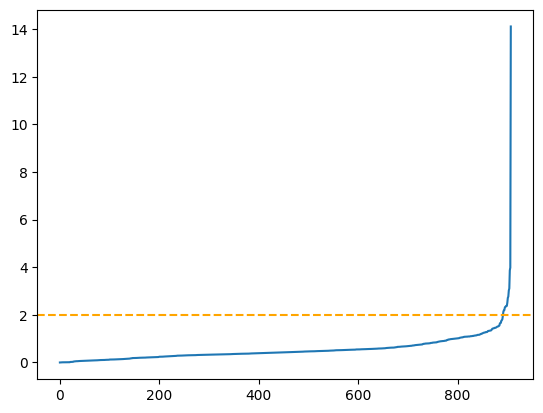

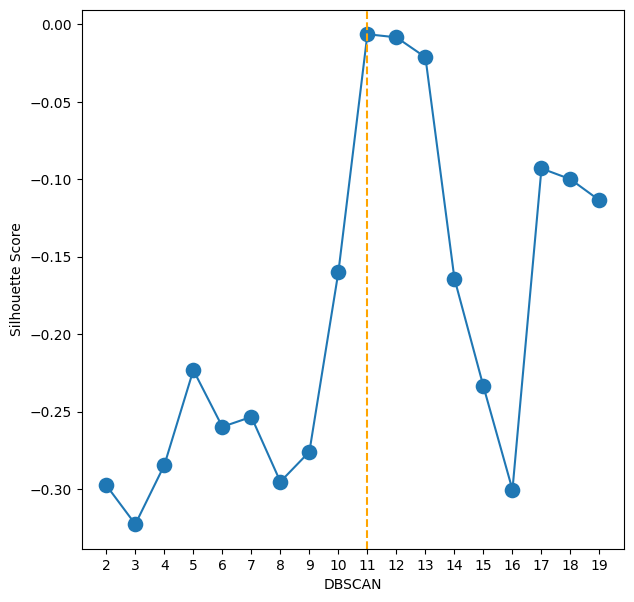

In [7]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

nn = NearestNeighbors(n_neighbors = 7).fit(imputed_data)
dist , ind = nn.kneighbors(imputed_data)

#sort the distances
dist = np.sort(dist,axis = 0)[:,1]

# drawing the sorted distance - distribution plot
plt.plot(dist)

# draw a line at the chosen value of eps
plt.axhline(y = 2.0, color = 'orange', ls = '--')

# Finding min_samples using silhouette_score
ss =[]
for ms in range(2,20):
    dbscan = DBSCAN(eps = 0.6, min_samples = ms)
    dbscan.fit(imputed_data)
    ss.append(silhouette_score(imputed_data, dbscan.labels_))

ss_series = pd.Series(ss, index = range(2,20))

#Plotting the graph
plt.figure(figsize = (7,7))
plt.xticks(range(2,20))
ax = sns.lineplot(y = ss_series, x = ss_series.index)
ax = sns.scatterplot(y = ss_series, x = ss_series.index, s = 150)
ax = ax.set(xlabel = 'DBSCAN', 
            ylabel = 'Silhouette Score')
plt.axvline(x = 11.0, color = 'orange', ls = '--')



#### From the above plots , we can tell that eps = 2, min samples = 11

In [8]:
dbscan = DBSCAN(eps = 2, min_samples = 11)
dbscan.fit(imputed_data)

# Adding labels to the dataFrame
imputed_data['labels'] = pd.Series(dbscan.labels_)

# Dropping outliers
data_clean = imputed_data.drop(imputed_data[imputed_data['labels'] == -1].index, axis=0)

# Dropping the labels column from the cleaned data
data_clean = data_clean.drop(columns='labels')

display(data_clean.head())
display(data_clean.info())

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50 [-LOG(mol/L)]
0,3.260,0.829,1.676,0.0,1.0,1.453,3.770
1,2.189,0.580,0.863,0.0,0.0,1.348,3.115
2,2.125,0.638,0.831,0.0,0.0,1.348,3.531
3,3.027,0.331,1.472,1.0,0.0,1.807,3.510
4,2.094,0.827,0.860,0.0,0.0,1.886,5.390


<class 'pandas.core.frame.DataFrame'>
Index: 885 entries, 0 to 907
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CIC0                885 non-null    float64
 1   SM1_Dz(Z)           885 non-null    float64
 2   GATS1i              885 non-null    float64
 3   NdsCH               885 non-null    float64
 4   NdssC               885 non-null    float64
 5   MLOGP               885 non-null    float64
 6   LC50 [-LOG(mol/L)]  885 non-null    float64
dtypes: float64(7)
memory usage: 55.3 KB


None

### STEP 05 : CALCULATING CORRELATION / MULTI-COLLINEARITY TEST
- Multi-collinearity occurs when two or more predictor variables in a regression model are highly correlated, which can make it difficult to determine the individual effect of each predictor on the response variable

- A simple way to check for multi-collinearity is to compute the correlation matrix of the predictor variables. High correlations (e.g., above 0.8 or below -0.8) suggest potential multi-collinearity.

In [9]:
# Checking for multi-collinearity 
print(data_clean.corr())     


                        CIC0  SM1_Dz(Z)    GATS1i     NdsCH     NdssC  \
CIC0                1.000000  -0.209329  0.140552  0.072237  0.230283   
SM1_Dz(Z)          -0.209329   1.000000 -0.170965 -0.114774  0.140877   
GATS1i              0.140552  -0.170965  1.000000 -0.011572  0.136014   
NdsCH               0.072237  -0.114774 -0.011572  1.000000  0.133408   
NdssC               0.230283   0.140877  0.136014  0.133408  1.000000   
MLOGP               0.445926   0.264364 -0.466752  0.013534 -0.025516   
LC50 [-LOG(mol/L)]  0.295577   0.440699 -0.408889  0.138338  0.101762   

                       MLOGP  LC50 [-LOG(mol/L)]  
CIC0                0.445926            0.295577  
SM1_Dz(Z)           0.264364            0.440699  
GATS1i             -0.466752           -0.408889  
NdsCH               0.013534            0.138338  
NdssC              -0.025516            0.101762  
MLOGP               1.000000            0.683959  
LC50 [-LOG(mol/L)]  0.683959            1.000000  


#### There are no variables that show high correlations (above 0.8 or below -0.8)

### STEP 06 : DATA VISUALIZATION

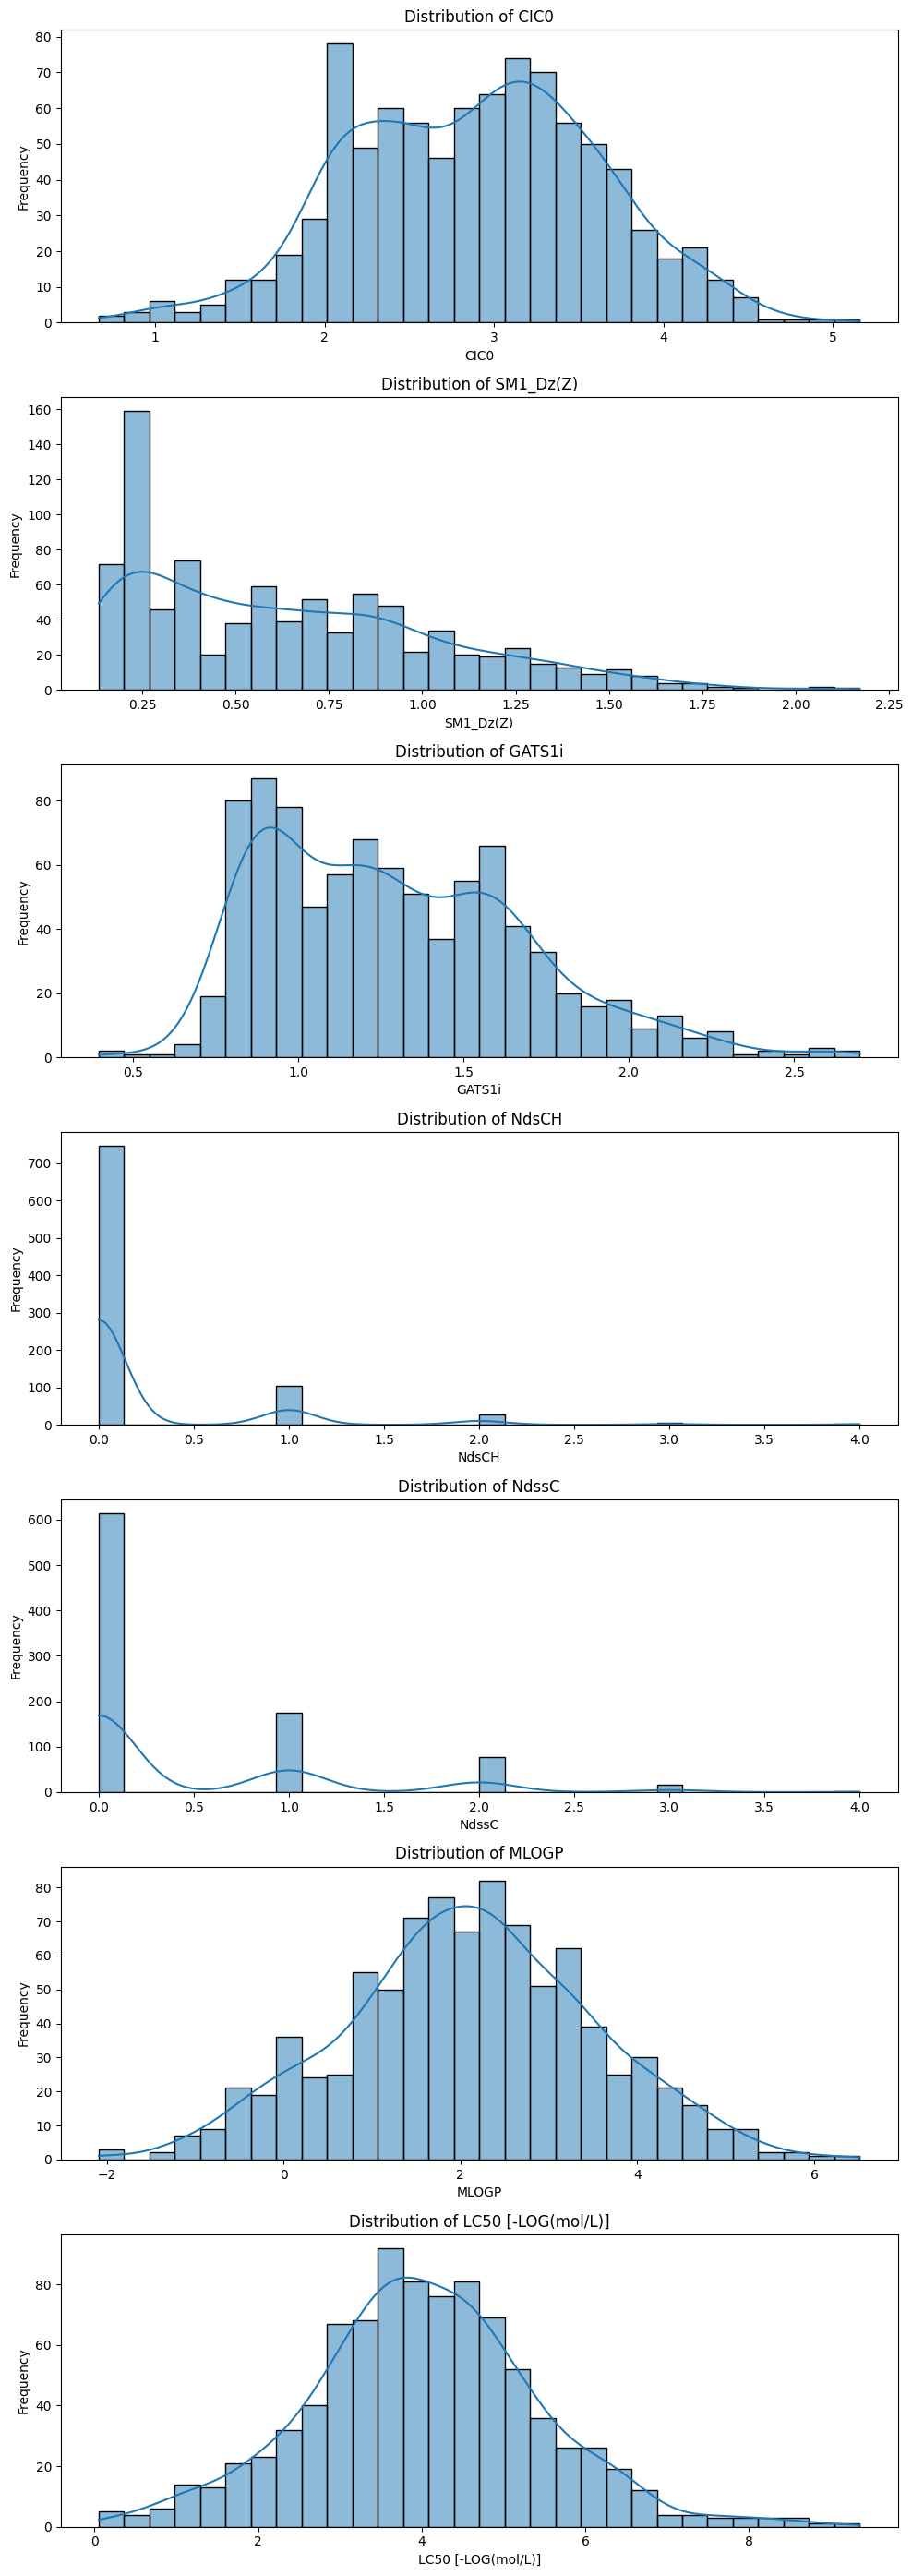

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

num_columns = data_clean.shape[1]
fig, axes = plt.subplots(num_columns, 1, figsize=(10, num_columns * 4))

# Foe every column create a histogram
for i, column in enumerate(data_clean.columns):
    sns.histplot(data_clean[column], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


#### OBSERVATION ON THE HISTOGRAMS

- The distribution of MLOGP and LC50 appears to be approximately normal distribution. 

- The distribution of NdssC and NdsCH shows that most of the values are 0.

### STEP 07 : DATA PREPARATION

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = data_clean.copy()

scaler = StandardScaler()
scaler.fit(data_clean)
scaled = scaler.transform(data_clean)
scaled_data = pd.DataFrame(scaled, columns = data.columns )

X = scaled_data.drop('LC50 [-LOG(mol/L)]', axis = 1)
y = scaled_data['LC50 [-LOG(mol/L)]']  

# Splitting of the dataset as per 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

display(scaled_data)

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50 [-LOG(mol/L)]
0,0.514731,0.455722,0.974498,-0.381059,0.745621,-0.454540,-0.179004
1,-0.940724,-0.155088,-1.095559,-0.381059,-0.584771,-0.529271,-0.639950
2,-1.027698,-0.012811,-1.177037,-0.381059,-0.584771,-0.529271,-0.347196
3,0.198091,-0.765899,0.455074,1.441844,-0.584771,-0.202590,-0.361975
4,-1.069826,0.450816,-1.103198,-0.381059,-0.584771,-0.146364,0.961046
...,...,...,...,...,...,...,...
880,0.806909,-0.584373,-1.065005,1.441844,2.076013,0.751829,0.547954
881,-0.109036,0.207963,2.374905,-0.381059,2.076013,-0.964845,-0.644172
882,1.047447,0.561203,-1.085374,3.264747,3.406406,1.346118,0.011005
883,-0.068267,1.839244,-0.550673,-0.381059,0.745621,-0.843852,0.909674


## REGRESSION MODELS

### LINEAR REGRESSION: 
- Linear regression is a type of supervised machine learning algorithm that computes the linear relationship between the dependent variable and one or more independent features by fitting a linear equation to observed data.

- When there is only one independent feature, it is known as Simple Linear Regression, and when there are more than one feature, it is known as Multiple Linear Regression.

##### Why should we use it?
  - Clear coefficients in the model's equation elucidate the impact of each independent variable on the dependent variable.
  - Facilitates a deeper understanding of the underlying dynamics.

  - Transparent and easy to implement.
  - Serves as a foundational concept for more complex algorithms.

  - Basis for various advanced models.


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error

scores = pd.DataFrame(index=['R2_score', 'Adj_R2_score', 'MAE', 'MSE']) 

# linear regression model
model = LinearRegression()

# Fit the model to the training data
model = model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# EVALUATION METRICS
print('CALCULATING EVALUATION METRICS FOR LINEAR REGRESSION:')

# Calculating R-squared
r2 = r2_score(y_test, y_pred)

# Calculating Adjusted R-squared
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Calculating Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculating Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

scores['Linear'] = [r2, adjusted_r2, mae, mse] 

display(scores)

CALCULATING EVALUATION METRICS FOR LINEAR REGRESSION:


,Linear
R2_score,0.560921
Adj_R2_score,0.545424
MAE,0.506337
MSE,0.484044


### LASSO REGRESSION:
- Python’s Lasso Regression is a linear regression technique that chooses the most important characteristics in addition to predicting results. By adding a penalty term and reducing the size of less significant feature coefficients to zero, it promotes the use of simpler models.

##### Why should we use it?
  - Lasso regression performs automatic feature selection by shrinking less important feature coefficients to zero.

  - By imposing a penalty on the magnitude of coefficients, lasso regression helps prevent overfitting, particularly in models with many features.

  - Lasso regression can handle multicollinearity effectively, providing more stable and interpretable models.

  - Produces simpler and more interpretable models by including only the most relevant features.

  - Can enhance prediction accuracy, especially when dealing with high-dimensional data.

In [13]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

# Define the range of lambda (alpha) values
lambda_range = np.linspace(0, 0.01 ,20)

# Create LassoCV model with specified lambda range
lasso_cv = LassoCV(alphas = lambda_range, cv = 5)
lasso_cv.fit(X_train, y_train)

# Best lambda found by cross-validation
best_lambda = lasso_cv.alpha_

# Predict using the model with the best lambda
y_pred = lasso_cv.predict(X_test)

# EVALUATION METRICS
print('CALCULATING EVALUATION METRICS FOR LASSO REGRESSION:')

# Best lambda found by cross-validation
best_lambda = lasso_cv.alpha_
print(f"Best lambda/alpha: {best_lambda}")

# Calculating R-squared
r2 = r2_score(y_test, y_pred)

# Calculating Adjusted R-squared
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Calculating Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculating Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

scores['Lasso'] = [r2, adjusted_r2, mae, mse] 

display(scores)

CALCULATING EVALUATION METRICS FOR LASSO REGRESSION:
Best lambda/alpha: 0.004210526315789474


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_mo

,Linear,Lasso
R2_score,0.560921,0.561755
Adj_R2_score,0.545424,0.546287
MAE,0.506337,0.506460
MSE,0.484044,0.483126


### RIDGE REGRESSION:
- A Ridge regressor is basically a regularized version of a Linear Regressor. i.e to the original cost function of linear regressor we add a regularized term that forces the learning algorithm to fit the data and helps to keep the weights lower as possible.

##### Why should we use it?
  - Reduces the impact of multicollinearity by adding a penalty term, stabilizing coefficient estimates.

  - Often yields better predictive performance compared to ordinary linear regression, especially with high-dimensional data.

  - Shrinks coefficients, reducing overfitting by imposing a penalty on their size.

  - More robust to outliers and noise in the data due to the regularization term.

  - Balances bias and variance, potentially leading to models that generalize better on unseen data.

  - Allows tuning the regularization strength, providing flexibility in model optimization.

In [14]:
from sklearn.linear_model import RidgeCV

# Define the range of lambda (alpha) values
lambda_range = np.linspace(0, 0.01 ,20)

# Create LassoCV model with specified lambda range
ridge_cv = RidgeCV(alphas = lambda_range, cv = 5)
ridge_cv.fit(X_train, y_train)

# Best lambda found by cross-validation
best_lambda = ridge_cv.alpha_

# Predict using the model with the best lambda
y_pred = ridge_cv.predict(X_test)

# EVALUATION METRICS
print('CALCULATING EVALUATION METRICS FOR LASSO REGRESSION:')

# Best lambda found by cross-validation
best_lambda = ridge_cv.alpha_
print(f"Best lambda/alpha: {best_lambda}")

# Calculating R-squared
r2 = r2_score(y_test, y_pred)

# Calculating Adjusted R-squared
n = len(y_test)
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Calculating Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculating Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

scores['Ridge'] = [r2, adjusted_r2, mae, mse] 

display(scores)

CALCULATING EVALUATION METRICS FOR LASSO REGRESSION:
Best lambda/alpha: 0.01


,Linear,Lasso,Ridge
R2_score,0.560921,0.561755,0.560923
Adj_R2_score,0.545424,0.546287,0.545426
MAE,0.506337,0.506460,0.506336
MSE,0.484044,0.483126,0.484043


### POLYNOMIAL REGRESSION
- Polynomial regression extends linear regression by incorporating polynomial terms of the independent variables, allowing the model to capture non-linear relationships between the predictors and the response variable. This approach involves fitting a polynomial function to the data, which can model complex patterns and trends that linear models might miss.

##### Why should we use it?
  - Models relationships that are not strictly linear, allowing for more flexible curve fitting.

  - Can provide a better fit to data when the true relationship between variables is curved or more complex.

  - Allows for modeling interactions and non-linear effects that linear regression cannot capture.

  - Useful when data shows trends that follow polynomial patterns, such as quadratic or cubic relationships.

  - Builds on linear regression by adding polynomial terms, making it a natural progression for more sophisticated modeling.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Define the Lasso model
lasso = Lasso()

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.009, 0.019, 10)}

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_poly, y_train)

# Get the best model
best_lasso = grid_search.best_estimator_

# Predict using the best model
y_pred = best_lasso.predict(X_test_poly)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best value of lambda =", grid_search.best_params_['alpha'])

# Calculate adjusted R²
n = X_test_poly.shape[0]
p = X_test_poly.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

scores['Polynomial'] = [r2, adj_r2, mae, mse]
display(scores)


Best value of lambda = 0.009


,Linear,Lasso,Ridge,Polynomial
R2_score,0.560921,0.561755,0.560923,0.567476
Adj_R2_score,0.545424,0.546287,0.545426,0.485647
MAE,0.506337,0.506460,0.506336,0.500111
MSE,0.484044,0.483126,0.484043,0.476818


### DECISION TREE
- A decision tree is a versatile machine learning model used for both classification and regression tasks. It works by recursively splitting the dataset into subsets based on the value of input features, creating a tree-like structure where each internal node represents a decision based on a feature, and each leaf node represents an outcome or prediction.

##### Why should we use it?
  - Decision trees are easy to understand and interpret, as they visually represent decision-making processes.

  - Capable of modeling non-linear relationships between features and target variables.

  - Can highlight the importance of different features in predicting the target variable.

  - Suitable for both numerical and categorical data.

  - Unlike some other algorithms, decision trees do not require feature scaling.

  - Can be used for both classification and regression tasks.

In [16]:
from sklearn.tree import DecisionTreeRegressor

# Define the Decision Tree Regressor
tree = DecisionTreeRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Get the best model
best_tree = grid_search.best_estimator_

# Predict using the best model
y_pred = best_tree.predict(X_test)

# Calculate evaluation metrics
best_mae = mean_absolute_error(y_test, y_pred)
best_mse = mean_squared_error(y_test, y_pred)
best_r2 = r2_score(y_test, y_pred)

display("Best hyperparameters =", grid_search.best_params_)

# Calculate adjusted R²
n = X_test.shape[0]
p = X_test.shape[1]
adj_r2 = 1 - (1 - best_r2) * (n - 1) / (n - p - 1)

scores['RegressionTree'] = [best_r2, adj_r2, best_mae, best_mse]
display(scores)


'Best hyperparameters ='

{'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}

,Linear,Lasso,Ridge,Polynomial,RegressionTree
R2_score,0.560921,0.561755,0.560923,0.567476,0.499226
Adj_R2_score,0.545424,0.546287,0.545426,0.485647,0.481552
MAE,0.506337,0.506460,0.506336,0.500111,0.534802
MSE,0.484044,0.483126,0.484043,0.476818,0.552058


## CONCLUSION
#### - Polynomial Regression is the best performing model based on highest R2 score and adjusted R2 score and lowest MAE and MSE.
#### - Regression Tree is the worst performing model according to the same metrics.
#### - Linear, Lasso, and Ridge Regression have similar and intermediate performance, with Lasso Regression having a slight edge.

### Therefore, Polynomial Regression would be the preferred model for predicting LC50, as it provides the best performance metrics among the evaluated models.